
# Partitioning a Square with Hyperplanes

This notebook illustrates the partitioning algorithm on a **simple and visualizable example**.
We consider the unit square in the plane and partition it using three hyperplanes. 
This demonstrates both the use of rational polytopes and hyperplanes as data structures, 
and the algorithm that produces the partition and its associated decision tree.


## Step 1. Imports and Setup

In [3]:
from fractions import Fraction
import numpy as np
import matplotlib.pyplot as plt

from polypart.geometry import Polytope, Hyperplane
from polypart.ftyping import as_fraction_vector
from polypart.ppart import build_partition_tree
from polypart.io import save_tree

# Alternative:
# from polypart import *

plt.rcParams["figure.figsize"] = (6, 6)
np.random.seed(7)


## Step 2. Define the Polytope

We begin with the unit square $[0,1]\times[0,1]$.  
In inequality form this is described by:
$[-x \leq 0, \quad x \leq 1, \quad -y \leq 0, \quad y \leq 1.]$

We construct a `Polytope` object with this representation.


In [4]:
A = [[-1, 0], [1, 0], [0, -1], [0, 1]]
b = [0, 1, 0, 1]
square = Polytope(A, b)
square

Polytope(dim=2, n_ineq=4, n_vertices=unknown)


## Step 3. Define Hyperplanes

We introduce three hyperplanes, all with rational coefficients:
- $x = \tfrac{1}{3}$, with normal $[1,0]$ and offset $\tfrac{1}{3}$.
- $y = \tfrac{1}{3}$, with normal $[0,1]$ and offset $\tfrac{1}{3}$.
- $y = x - \tfrac{1}{5}$, equivalently $x - y = \tfrac{1}{5}$, with normal $[1,-1]$ and offset $\tfrac{1}{5}$.


In [5]:
h1 = Hyperplane.from_coefficients([1, 0, Fraction(1, 3)])
h2 = Hyperplane.from_coefficients([0, 1, Fraction(1, 3)])
h3 = Hyperplane.from_coefficients([1, -1, Fraction(1, 5)])
hyperplanes = [h1, h2, h3]
hyperplanes

[Hyperplane(normal=array([Fraction(1, 1), Fraction(0, 1)], dtype=object), offset=Fraction(1, 3)),
 Hyperplane(normal=array([Fraction(0, 1), Fraction(1, 1)], dtype=object), offset=Fraction(1, 3)),
 Hyperplane(normal=array([Fraction(1, 1), Fraction(-1, 1)], dtype=object), offset=Fraction(1, 5))]


## Step 4. Build the Partition Tree

The `build_partition_tree` splits the polytope using the hyperplanes and constructs a decision tree representing the partition. 
It returns two results:
- `tree`: a decision tree encoding the partition,
- `n_parts`: the total number of regions generated.


In [6]:
tree, n_parts = build_partition_tree(square, hyperplanes)
print("Number of partitions:", n_parts)

Number of partitions: 7



## Step 5. Classify and Visualize Points

We can now use the decision tree to classify arbitrary points into regions.  
Here we generate random points in the square, classify them, and display the partitioning visually.  
The hyperplanes are also plotted as dashed lines.


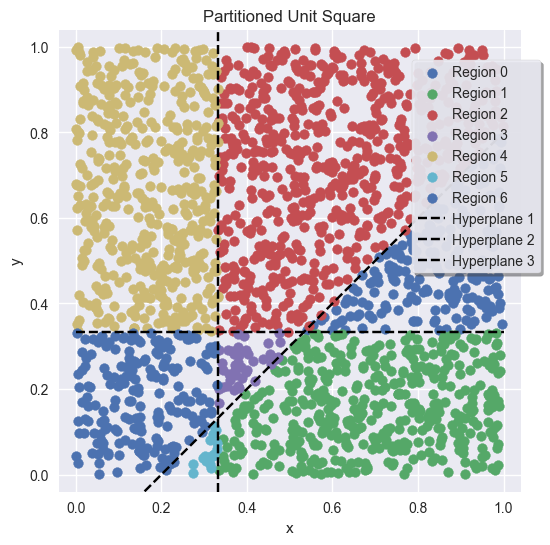

In [7]:
plt.style.use("seaborn-v0_8")
# Generate random points
n_points = 2000
points = np.random.rand(n_points, 2)

# Query the partition tree for each point
partitions = [tree.classify(as_fraction_vector(point)) for point in points]

# Plot the points colored by their partition
fig, ax = plt.subplots(figsize=(6, 6))
labels = np.array([p._id for p in partitions])
unique_labels = np.unique(labels)
for i, lab in enumerate(unique_labels):
    mask = labels == lab
    ax.scatter(
        points[mask, 0],
        points[mask, 1],
        label=f"Region {lab}",
    )

# Plot the hyperplanes as dashed lines with labels
x = np.linspace(0, 1, 100)
for i, h in enumerate(hyperplanes):
    # convert Fraction-based coefficients to floats for plotting
    a = float(h.normal[0])
    b = float(h.normal[1])
    c = float(h.offset)
    if b != 0:
        y = (c - a * x) / b
        ax.plot(x, y, "k--", label=f"Hyperplane {i+1}")
    else:
        x_const = c / a
        ax.axvline(x=x_const, color="k", linestyle="--", label=f"Hyperplane {i+1}")
# Place legend on the axis after plotting everything
ax.legend(
    loc="upper left",
    frameon=True,
    fontsize=10,
    shadow=True,
    framealpha=0.9,
    bbox_to_anchor=(0.75, 0.95),
    handletextpad=0.5,
)

ax.set_aspect("equal")
ax.set_xlim(-0.04, 1.04)
ax.set_ylim(-0.04, 1.04)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Partitioned Unit Square")
plt.show()


## Step 6. Persisting the Tree (Optional)

The decision tree can be saved to disk for reuse, so that new points can be classified later without recomputation.


In [8]:
# save_tree(tree, "square_partitions.json")